For equation:
$$
\left\{\begin{array}{l}
u_{t}+f(u)_{x}=0 \\
u(x, 0)=u^{0}(x)
\end{array}\right.
$$

numerical scheme
$$
u_{j}^{n+1}=u_{j}^{n}-\frac{\Delta t}{\Delta x}\left[\hat{f}_{j+1 / 2}-\hat{f}_{j-1 / 2}\right]
$$

In [1]:
using PyPlot
N = 100
Nt = 101

dx = 1/N
dt = 1/(Nt-1)

x = Vector(0:dx:1-dx)

# initial condition u0=sin(2\pi x)
u0 = sinpi.(2 .* x)

# Periodic boundary
handleleft(u,i) = (i==1) ? u[end] : u[i-1]
handleright(u,i) = (i==length(u)) ? u[1] : u[i+1]

# burger's equation
# ∂u/∂t + ∂f(u)/∂x = 0
# where f(u) = u^2/2
f(u) = u^2/2
# f'(u), Jacobian of f(u)
Jf(u) = u 

# explicit finite volume method
function solve_fvm()
    sol = zeros(length(u0),Nt)
    sol[:,1] = copy(u0)
    du = Float64.(similar(u0))
    @inbounds for ti in 2:Nt # Eliminates array bounds checking within expressions
        update!(du,sol[:,ti-1])
        sol[:,ti] = sol[:,ti-1] + dt .* du
    end
    return sol
end

# (u^{n+1} - u^{n})/dt + (F_{i+1/2} - F_{i-1/2})/dx = 0
# F_{i+1/2} = Flux(u_{i}, u_{i+1})
# F_{i-1/2} = Flux(u_{i-1}, u_{i})
function update!(du, u)
    @inbounds for i in 1:length(u) 
        du[i] = - (Flux(u[i], handleright(u,i)) - Flux(handleleft(u,i),u[i]))/dx
    end
end

# plot function
function myplot(sol)
    begin
        plot(x,sol[:,1], label="t=$((1-1)*dt)")
        plot(x,sol[:,21], label="t=$((21-1)*dt)")
        plot(x,sol[:,41], label="t=$((41-1)*dt)")
        plot(x,sol[:,61], label="t=$((61-1)*dt)")
        plot(x,sol[:,81], label="t=$((81-1)*dt)")
        plot(x,sol[:,101], label="t=$((101-1)*dt)")
        legend()
        grid()
        show()
    end
    return
end

myplot (generic function with 1 method)

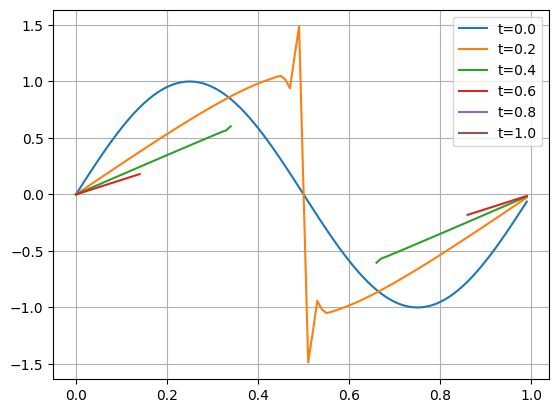

In [2]:
# Unstable Flux
# F_{i+1/2} = 0.5*(f(u_{i}) + f(u_{i+1}))
function Flux(ul, ur)
    return 0.5*(f(ul)+f(ur))
end

sol = solve_fvm()
myplot(sol)

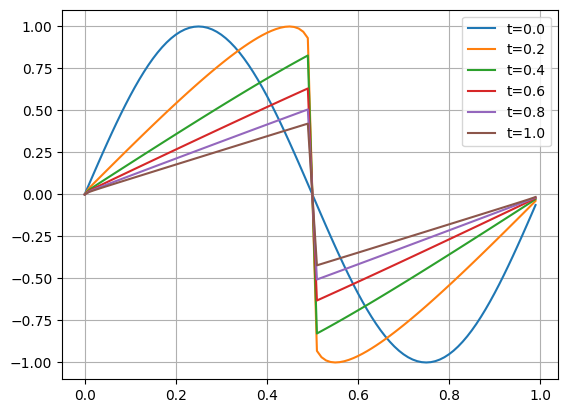

In [3]:
# Godunov's scheme
# F_{i+1/2} = u_{i+1} > u_{i} : min_{u_{i} <= u <= u_{i+1}}(f(u)) ? max_{u_{i+1} <= u <= u_{i}}(f(u))
# get the minimum of f maybe complicated, but if f is strictly convex, which has a single minimum at point w and no local maxima
# we could simplified the flux as:
# F_{i+1/2} = max(f(max(u_{i}, w)), f(min(u_{i+1}, w)))
# f = u^2/2, so we got w = 0 here
function Flux(ul, ur)
    return max(f(max(ul, 0)), f(min(ur, 0)))
end

sol = solve_fvm()
myplot(sol)

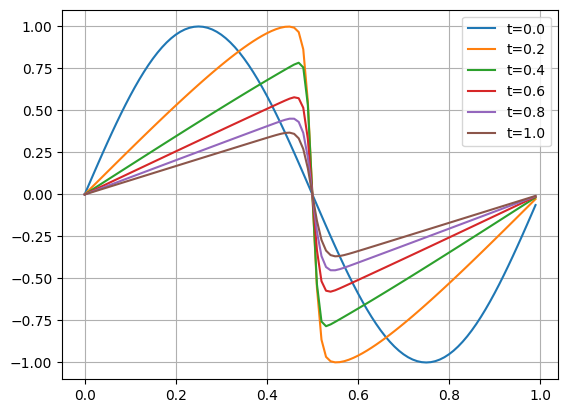

In [4]:
# Lax–Friedrichs scheme
# F_{i+1/2} = 0.5*(f(u_{i}), f(u_{i+1}) - α*(u_{i}-u_{i+1}))
# α = max_u|f'(u)|
α = maximum(abs.(Jf.(u0)))
function Flux(ul, ur)
    return 0.5*(f(ul)+f(ur) - α*(ur-ul))
end

sol = solve_fvm()
myplot(sol)

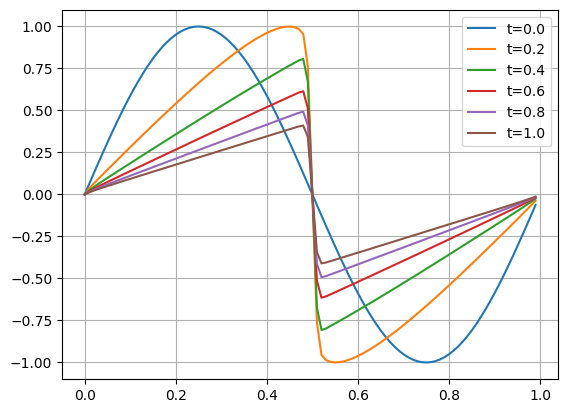

In [5]:
# Local Lax–Friedrichs scheme
# F_{i+1/2} = 0.5*( f(u_{i}) + f(u_{i+1}) - α*(u_{i}-u_{i+1}) )
# α = max_{ul,ur}|f'(u)|
α_f(ul,ur) = max(abs(Jf(ul)), abs(Jf(ur)))
function Flux(ul, ur)
    return 0.5*(f(ul)+f(ur) - α_f(ul,ur)*(ur-ul))
end

sol = solve_fvm()
myplot(sol)

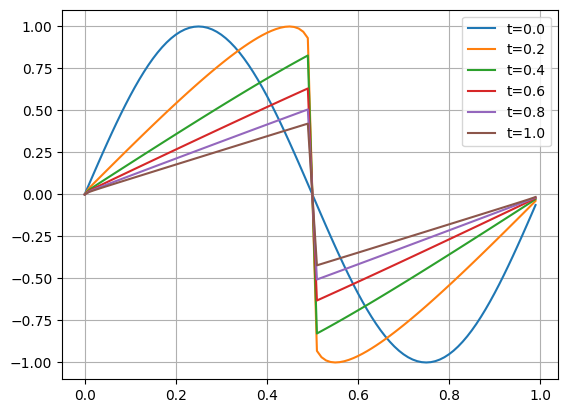

In [6]:
# Roe Scheme
# F_{i+1/2} = α >= 0 : f(u_{i}) ? f(u_{i+1})
# α = (f(u_{i+1}) - f(u_{i}))/(u_{i+1} - u_{i})
function Flux(ul, ur)
    return (f(ur)-f(ul))/(ur-ul)>=0 ? f(ul) : f(ur)
end

sol = solve_fvm()
myplot(sol)

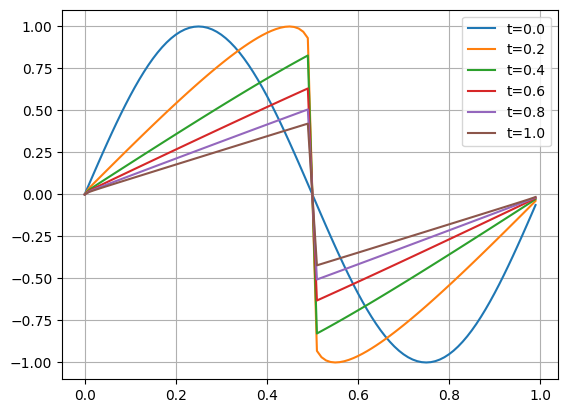

In [8]:
#  Engquist-Osher Scheme
# F_{i+1/2} = f⁺(u_{i}) + f⁻(u_{i+1})
# f⁺(u) = \int_{0}^{u} max(f'(u),0)du + f(0)
# f⁻(u) = \int_{0}^{u} min(f'(u),0)du
# note f'(u) = u, so we could write the integrate explicily
# or use some numerical method to compute the integrate like QuadGK.jl
f⁺(u) = u>0 ? u^2/2 : 0
f⁻(u) = u<0 ? u^2/2 : 0

function Flux(ul, ur)
    return f⁺(ul) +  f⁻(ur)
end

sol = solve_fvm()
myplot(sol)